## Trabalho final desenvolvido pelos alunos:
- Itor Carlos Souza Queiroz
- Lanna Luara Novaes Silva

Instalação das dependências necessárias

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, filters, feature
from skimage.util import img_as_float
from skimage.filters import sobel
from skimage.io import imread
from roboflow import Roboflow
import roboflow
import zipfile
import os
import requests



Define o diretório onde ficará as imagens do dataset que está sendo usado no trabalho

In [28]:
caminho_diretorio = 'dices/'
arquivos = [f for f in os.listdir(caminho_diretorio) if f.endswith(('.png', '.jpg', '.jpeg'))]

Cria uma função para ler as imagens da pasta "dices" para exibir as imagens antes de realizar as próximas operações

In [29]:
def exibe_grade(lista_imagens, titulos, mapa_cor=None):
    n_imagens = len(lista_imagens)
    numero_colunas = 4
    numero_linhas = (n_imagens // numero_colunas) + (1 if n_imagens % numero_colunas != 0 else 0)

    plt.figure(figsize=(15, numero_linhas * 4))
    for i, imagem in enumerate(lista_imagens):
        plt.subplot(numero_linhas, numero_colunas, i + 1)
        plt.imshow(imagem, cmap=mapa_cor if len(imagem.shape) == 2 else None)
        plt.axis("off")
        plt.title(titulos[i])
    plt.tight_layout()
    plt.show()

Definição de uma função para converter as imagens para a escala de cinza. Primeiramente será removido o canal alpha, referente a transparência, caso o mesmo exista.

In [ ]:
def converter_para_cinza(lista_entrada):
    lista_saida = []
    for img in lista_entrada:
        # Remove canal alpha (transparência) se existir
        if len(img.shape) == 3 and img.shape[-1] == 4:
            img = img[:, :, :3]

        cinza = color.rgb2gray(img)
        lista_saida.append(cinza)
    return lista_saida

Exibição das imagens originais, ou seja, anterior as operações do trabalho

Exibindo imagens originais...


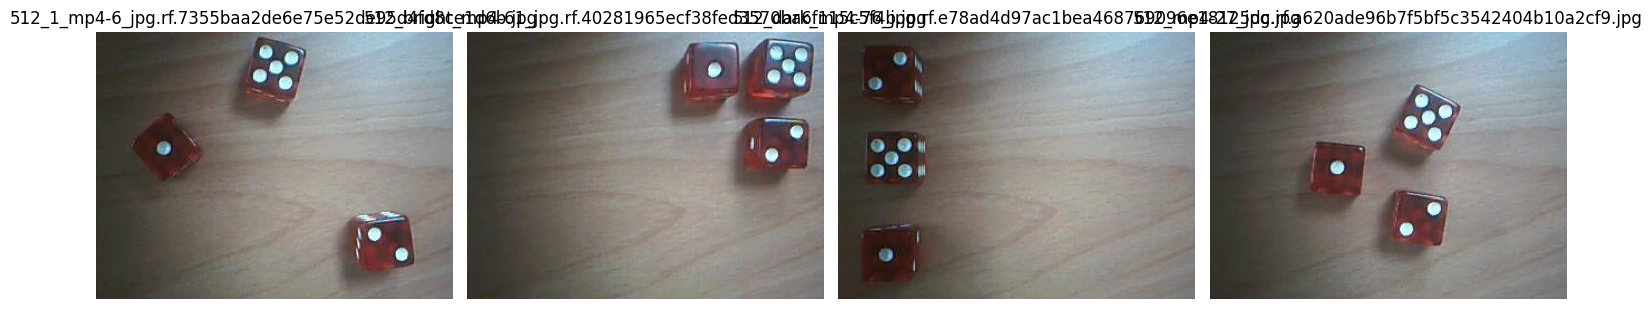

In [30]:
imagens_originais = []
for nome in arquivos:
    img = io.imread(os.path.join(caminho_diretorio, nome))
    imagens_originais.append(img)


print("Exibindo imagens originais...")
exibe_grade(imagens_originais, arquivos)